# Import necessary libraries
SAFEP_parse.py contains all the functions and library calls necessary to run the notebook
# Required libraries:
- numpy
- pandas
- matplotlib
- alchemlyb (pip install git+https://github.com/alchemistry/alchemlyb)
- natsort (for sorting file names)
- glob (for unix-like file paths)



# IMPORTANT: Make sure the temperature (set below) matches the temperature you used to run the simulations.

In [1]:
import warnings
import logging
import copy
from AFEP_parse import *
import matplotlib as mpl
plt.rcParams['figure.dpi'] = 150

logging.captureWarnings(True)
warnings.simplefilter(action='ignore', category=FutureWarning)
#logger = logging.getLogger("alchemlyb.parsers.NAMD")
#logging.disable(level='CRITICAL')

In [2]:
def checkPaths(paths, nDone):
    goodpaths = []
    for path in paths:
        feps = glob(path+pattern)
        countDone = 0
        for fep in feps:
            with open(fep) as f:
                if 'Free' in f.read():
                    countDone+=1
        if countDone == nDone:
            goodpaths.append(path)
    
    return goodpaths

In [89]:
def processLeg(root, prefix, nDone, checkReplicas):
    paths = glob(root+prefix+'*/')
    if checkReplicas==True:
        paths = checkPaths(paths, nDone)
        
    print(paths)
    u_nks, cumulative, perWindow, affix = batchProcess(paths, RT, decorrelate, pattern, temperature, detectEQ)

    perWindow[('mean', 'df')] = np.mean(perWindow.loc[:, (slice(None), 'df')], axis=1)
    perWindow[('mean', 'ddf')] = np.mean(perWindow.loc[:, (slice(None), 'ddf')], axis=1)
    perWindow[('mean', 'dG_f')] = np.mean(perWindow.loc[:, (slice(None), 'dG_f')], axis=1)
    perWindow[('mean', 'dG_b')] = np.mean(perWindow.loc[:, (slice(None), 'dG_b')], axis=1)

    reps = list(set(perWindow.columns.get_level_values(0)))
    for key in reps:
        perWindow[(key, 'diff')] = perWindow[(key, 'dG_f')]+perWindow[(key, 'dG_b')]

    keys = set(cumulative.columns.get_level_values(0))
    colors = ['#0072B2', '#D55E00', '#CC79A7', '#009E73', '#E69F00', '#56B4E9']
    keyColors = {}
    i = 0
    for key in keys:
        keyColors[key] = colors[i]
        i += 1
        
    return reps, keyColors, u_nks, cumulative, perWindow, affix

In [4]:
def processAllLegs(root, prefixes, nDone=41, checkReplicas=False):
    meta_unks = {}
    meta_cumulative = {}
    meta_perWindow = {}
    meta_affix = {}
    meta_keyColors = {}
    meta_reps = {}
    feps = np.round(np.linspace(0, 1, nDone),3)
    meta_fs = {}
    meta_bs = {}
    meta_bes = {}
    meta_fes = {}
    for prefix in prefixes:
        if len(glob(root+'/'+prefix+'*/')) > 0:
            reps, keyColors, u_nks, cumulative, perWindow, affix = processLeg(root, prefix, nDone, checkReplicas)

            meta_reps[prefix] = reps
            meta_keyColors[prefix] = keyColors
            meta_unks[prefix] = u_nks
            meta_cumulative[prefix] = cumulative
            meta_perWindow[prefix] = perWindow
            meta_affix[prefix] = affix

            fs = {}
            bs = {}
            fes = {}
            bes = {}

            for l in [x for x in meta_reps[prefix] if x != "mean"]:
                u_nks = meta_unks[prefix]
                forward, forward_error, backward, backward_error = doConvergence(u_nks[l], feps)
                fs[l] = forward
                fes[l] = forward_error
                bs[l] = backward
                bes[l] = backward_error

            meta_fs[prefix]=fs
            meta_bs[prefix]=bs
            meta_fes[prefix]=fes
            meta_bes[prefix]=bes
    
    return {'unks':meta_unks, 'cumulatives':meta_cumulative, 'perWins':meta_perWindow, 'affixes':meta_affix, 'keyColors':meta_keyColors, 'reps':meta_reps, 'fs':meta_fs, 'bs':meta_bs, 'fes':meta_fs, 'bes':meta_bes}

In [86]:
## Membranes
root = '/home/ems363/Documents/ELIC_DCDs_Analyses/'
#root = '/home/ezry/winHome/Documents/ELIC_Data/ELIC/'
systems = ['PCPGPE211', 'PCPG31', 'POPC120']
longSysNames = {'PCPGPE211':r'$\rm2_{POPC}:1_{POPE}:1_{POPG}$', 'PCPG31':r'$\rm3_{POPC}:1_{POPG}$', 'POPC120':'POPC'}

prefixes = ['POCE', 'POCG', 'POEG', 'POGE']
longNames = {'POCE':'POPC to POPE', 'POCG':'POPC to POPG', 'POEG':'POPE to POPG', 'POGE':'POPG to POPE'}

pattern = '*fepout'
checkReplicas = True

In [6]:
temperature = 303.15
RT = 0.00198720650096 * temperature # ca. 0.59kcal/mol
decorrelate = True #Flag for decorrelation of samples
detectEQ = False #Flag for automated equilibrium detection
DiscrepancyFitting = 'LS' #ML = fit PDF of discrepancies with a normal distribution maximum likelihood estimator. LS = fit CDF of discrepancies with a normal distribution least-squares estimator

In [7]:
allSys = {}

for sys in systems:
    allSys[sys] = processAllLegs(root+sys+'/', prefixes, 41, checkReplicas)

['/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_111/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_32/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_69/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_84/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_9/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_111/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_32/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_69/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_84/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_9/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
['/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_115/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_22/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_5/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_62/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_95/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_115/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_22/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_5/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_62/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_95/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
['/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_1/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_104/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_18/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_47/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_71/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_1/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_104/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_18/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_47/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_71/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
['/home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCE_1/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCE_18/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCE_40/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCE_90/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCE_1/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCE_18/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCE_40/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCE_90/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
['/home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCG_26/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCG_48/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCG_5/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCG_64/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCG_99/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCG_26/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCG_48/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCG_5/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCG_64/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POCG_99/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
['/home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POGE_10/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POGE_102/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POGE_32/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POGE_72/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POGE_10/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POGE_102/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POGE_32/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POGE_72/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
['/home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCE_120/', '/home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCE_24/', '/home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCE_48/', '/home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCE_72/', '/home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCE_84/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCE_120/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCE_24/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCE_48/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCE_72/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCE_84/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
['/home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCG_108/', '/home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCG_12/', '/home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCG_36/', '/home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCG_60/', '/home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCG_96/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCG_108/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCG_12/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCG_36/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCG_60/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POCG_96/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
['/home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POEG_19/', '/home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POEG_23/', '/home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POEG_49/', '/home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POEG_55/', '/home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POEG_7/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POEG_19/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POEG_23/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POEG_49/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POEG_55/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/POPC120/POEG_7/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'


In [90]:
allSys['PCPGPE211'] = processAllLegs(root+'PCPGPE211'+'/', prefixes, 41)

['/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_111/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_32/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_69/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_84/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_9/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_111/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_32/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_69/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_84/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_9/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
['/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_115/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_22/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_5/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_62/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_95/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_115/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_22/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_5/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_62/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_95/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
['/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_1/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_104/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_18/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_47/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_71/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_Good/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_1/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_104/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_18/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_47/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_71/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_Good/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'


In [91]:
#Uniquely necessary for PCPG3:1 membrane system

for dat in allSys['PCPG31'].keys():
    allSys['PCPG31'][dat]['POEG'] = copy.deepcopy(allSys['PCPG31'][dat]['POGE'])

In [92]:
def cumulativePlot(system, leg, keys, keyColors, theax):
    cumulative = system['cumulatives'][leg]
    X = cumulative.index
    for key in keys:
        Y = cumulative[(key, 'f')]*RT
        theColor = keyColors[key]
        theax.plot(X, Y, marker=None, label=key, linewidth=1, color=theColor)
        #finalMean = cumulative.loc[1].iloc[0]*RT
        finalMean = np.mean(cumulative.loc[1, (slice(None), 'f')])
    theax.axhline(finalMean*RT, color='gray', linestyle='-.', linewidth=1)
    
    return theax


def convergencePlot(system, leg, keys, keyColors, theax):
    fs = system['fs'][leg]
    bs = system['bs'][leg]
    for l in [x for x in keys if x != "mean"]:
        theax.plot(np.arange(len(fs[l]))/len(fs[l])+0.1, np.multiply(fs[l], RT), marker='o', linewidth=1, color=keyColors[l], markerfacecolor='white', markeredgewidth=1, markeredgecolor=keyColors[l], ms=5)
        theax.plot(np.arange(len(bs[l]))/len(fs[l])+0.1, np.multiply(bs[l], RT), marker='o', linewidth=1, color=keyColors[l], markerfacecolor='white', markeredgewidth=1, markeredgecolor=keyColors[l], ms=5, linestyle='--')

    theax.xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    
    cumulative = system['cumulatives'][leg]
    finalMean = np.mean(cumulative.loc[1, (slice(None), 'f')])
    theax.axhline(y= finalMean*RT, linestyle='-.', color='gray')
    theax.plot(0, finalMean*RT, linewidth=1, color='black', label='Forward Time Sampling')
    theax.plot(0, finalMean*RT, linewidth=1, color='black', linestyle='--', label='Backward Time Sampling')

    #theax.legend()
    
    return theax


def hysteresisPlot(system, leg, keys, keyColors, theax):
    perWindow = system['perWins'][leg]
    # Hysteresis plot
    for key in keys:
        #plt.vlines(perWindow.index, np.zeros(len(perWindow)), perWindow[(key, 'dG_f')] + perWindow[(key, 'dG_b')], label=key, linewidth=2)
        theax.plot(perWindow.index, perWindow[(key, 'diff')]*RT, label=key, linewidth=0.5, alpha=0.8, color=keyColors[key])

    theax.plot(perWindow.index, perWindow[('mean', 'diff')]*RT, label='mean', linewidth=1.5, color='black')

    theax.set(ylim=(-1.25, 1.25))

    return theax

    
def hysteresisPDF(system, leg, keys, keyColors, theax):
    
    perWindow = system['perWins'][leg]
    # Hysteresis PDF
    diff = perWindow.loc[:, (slice(None), 'diff')]*RT
    X = diff.drop(columns='mean') #Including the mean in here would underestimate the skewness of the distribution
    Y = np.arange(len(X))/len(X)
    binNum = 20
    pdfY, pdfX = np.histogram(X, bins=binNum, density=True)
    pdfX = (pdfX[1:]+pdfX[:-1])/2


    #plot the data
    theax.plot(pdfX, pdfY,  label="Estimated Distribution")
    theax.set(xlim=(-1.25, 1.25))
    
    return theax


def makePlots(allSys, systems, prefixes, xlabel, ylabel, doPlot, sharey=True, sharex=True):
    fig, theaxes = plt.subplots(3,len(systems), sharex=sharex, sharey=sharey)
    pad = 5 # in points
    
    for sysID in np.arange(len(systems)):
        sysName = systems[sysID]
        system = allSys[sysName]
        print(f'Now making figures for: {sysName}')
        theaxes[2, sysID].set(xlabel=xlabel)
        theaxes[0, sysID].annotate(longSysNames[sysName], xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
        for prefID in np.arange(len(prefixes)):
            # Cumulative change in kT 
            leg = prefixes[prefID]
            try:
                keys = system['keyColors'][leg]
                keyColors = system['keyColors'][leg]
                theaxes[prefID, 0].set(ylabel=ylabel)
                theaxes[prefID, 0].annotate(longNames[leg], xy=(0, 0.5), xytext=(-theaxes[prefID, 0].yaxis.labelpad - pad, 0),
                        xycoords=theaxes[prefID, 0].yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center', rotation=90)

                theax = doPlot(system, leg, keys, keyColors, theaxes[prefID, sysID])
            except:
                continue
            
    fig.set_figheight(10)
    fig.set_figwidth(8)
    fig.tight_layout()
    
    return fig, theaxes


Now making figures for: PCPGPE211
Now making figures for: PCPG31
Now making figures for: POPC120


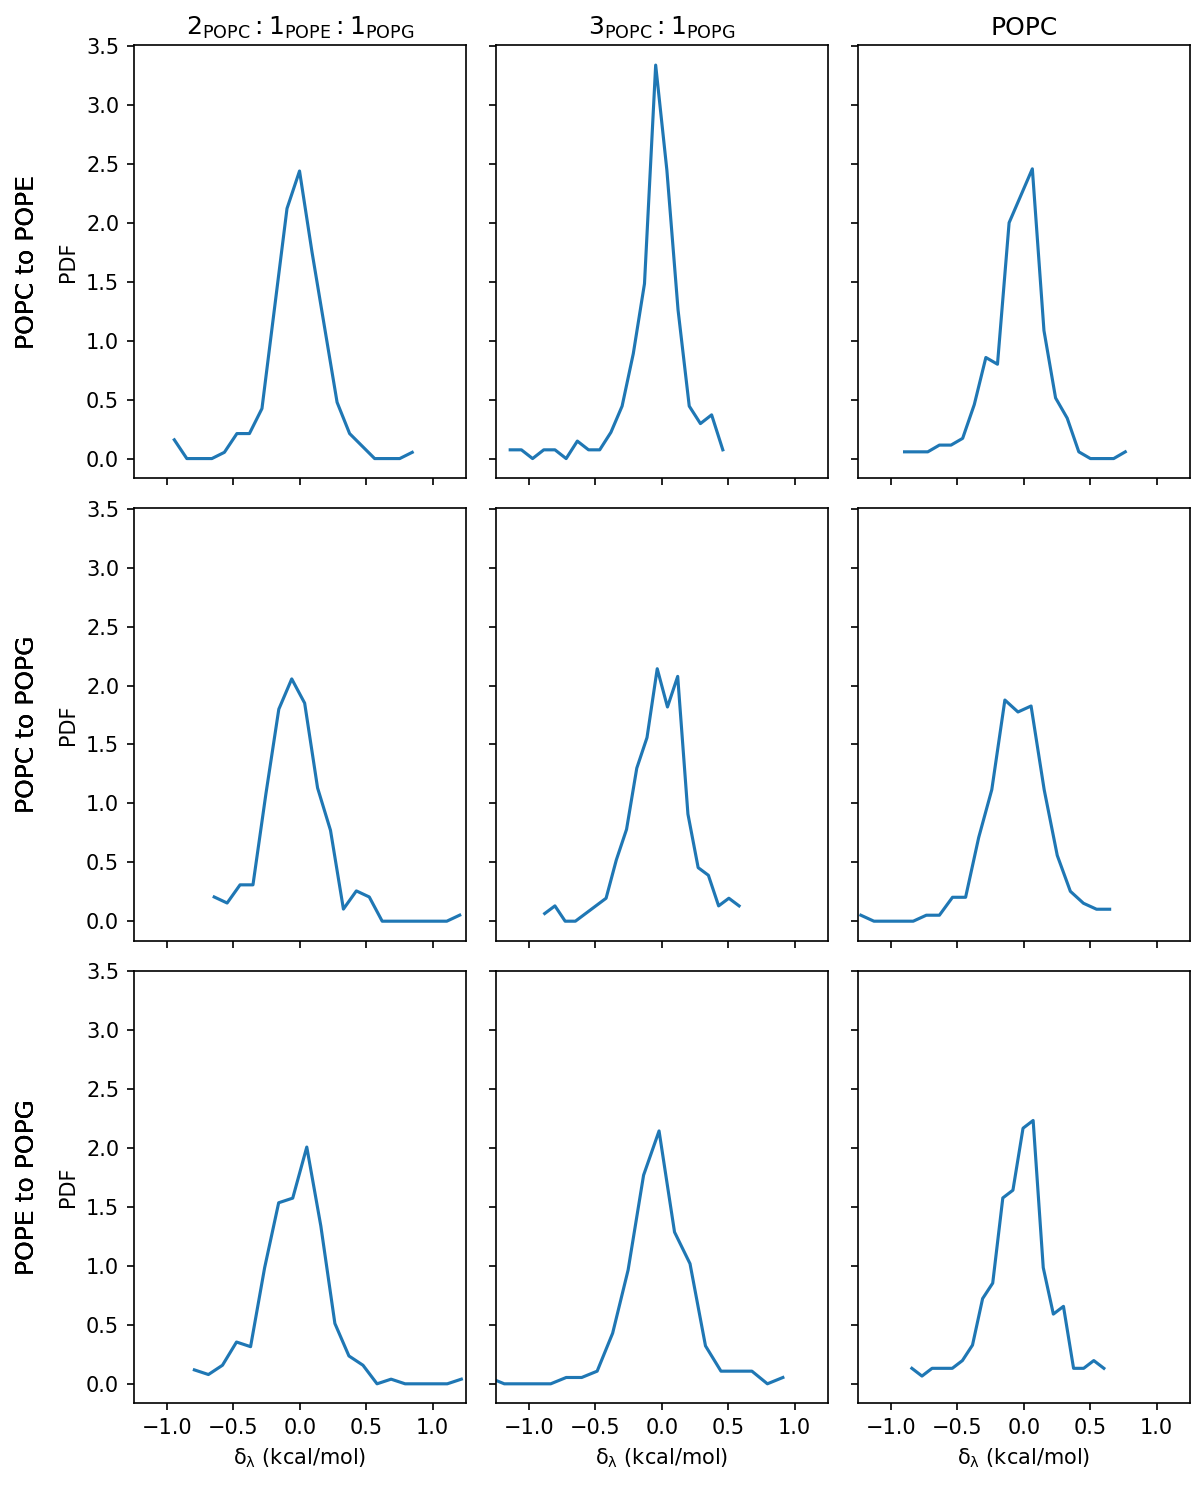

In [104]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\delta_{\lambda}$ (kcal/mol)', ylabel='PDF', doPlot=hysteresisPDF, sharey=True)
plt.savefig(f"{root}/DRAFT_S3.pdf")

Now making figures for: PCPGPE211
Now making figures for: PCPG31
Now making figures for: POPC120


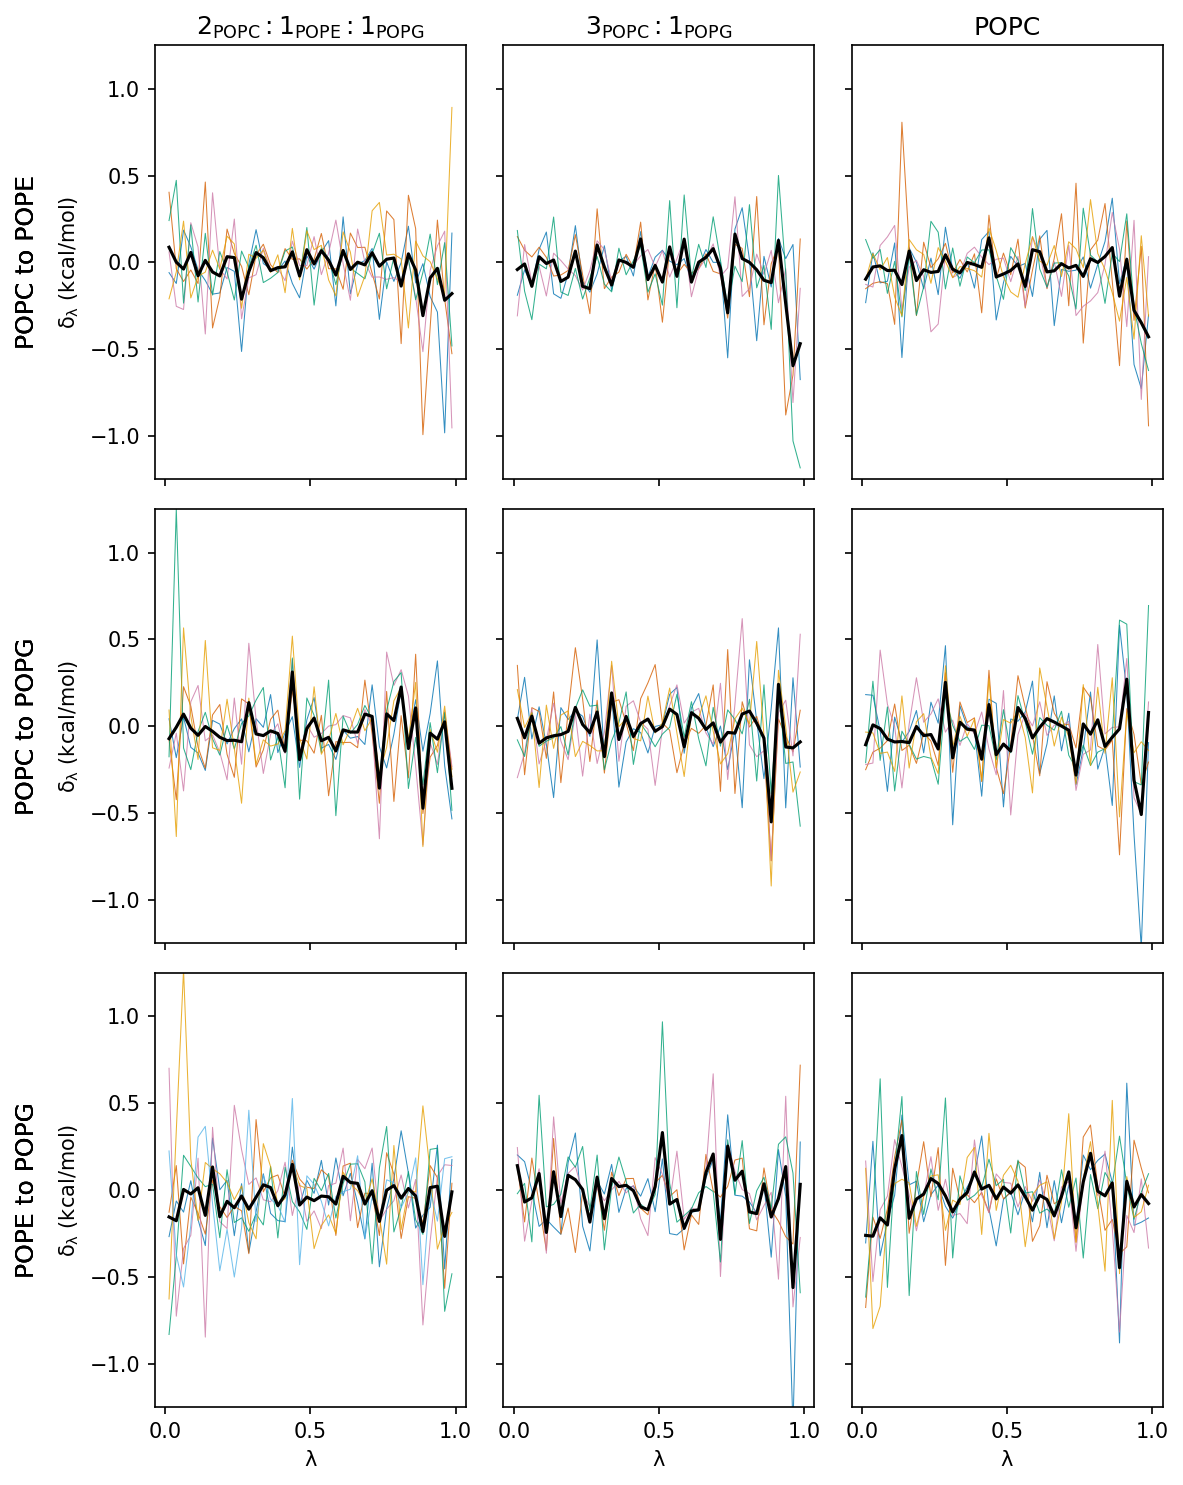

In [94]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\lambda$', ylabel=r'$\rm\delta_{\lambda}$ (kcal/mol)', doPlot=hysteresisPlot, sharey='row')
plt.savefig(f"{root}/DRAFT_S2.pdf")

In [95]:
for x in allSys['PCPG31']['fs']['POGE'].keys():
    allSys['PCPG31']['fs']['POEG'][x] = np.multiply(copy.deepcopy(allSys['PCPG31']['fs']['POGE'][x]), -1)
    
for x in allSys['PCPG31']['bs']['POGE'].keys():
    allSys['PCPG31']['bs']['POEG'][x] = np.multiply(copy.deepcopy(allSys['PCPG31']['bs']['POGE'][x]), -1)
                                                    

Now making figures for: PCPGPE211
Now making figures for: PCPG31
Now making figures for: POPC120


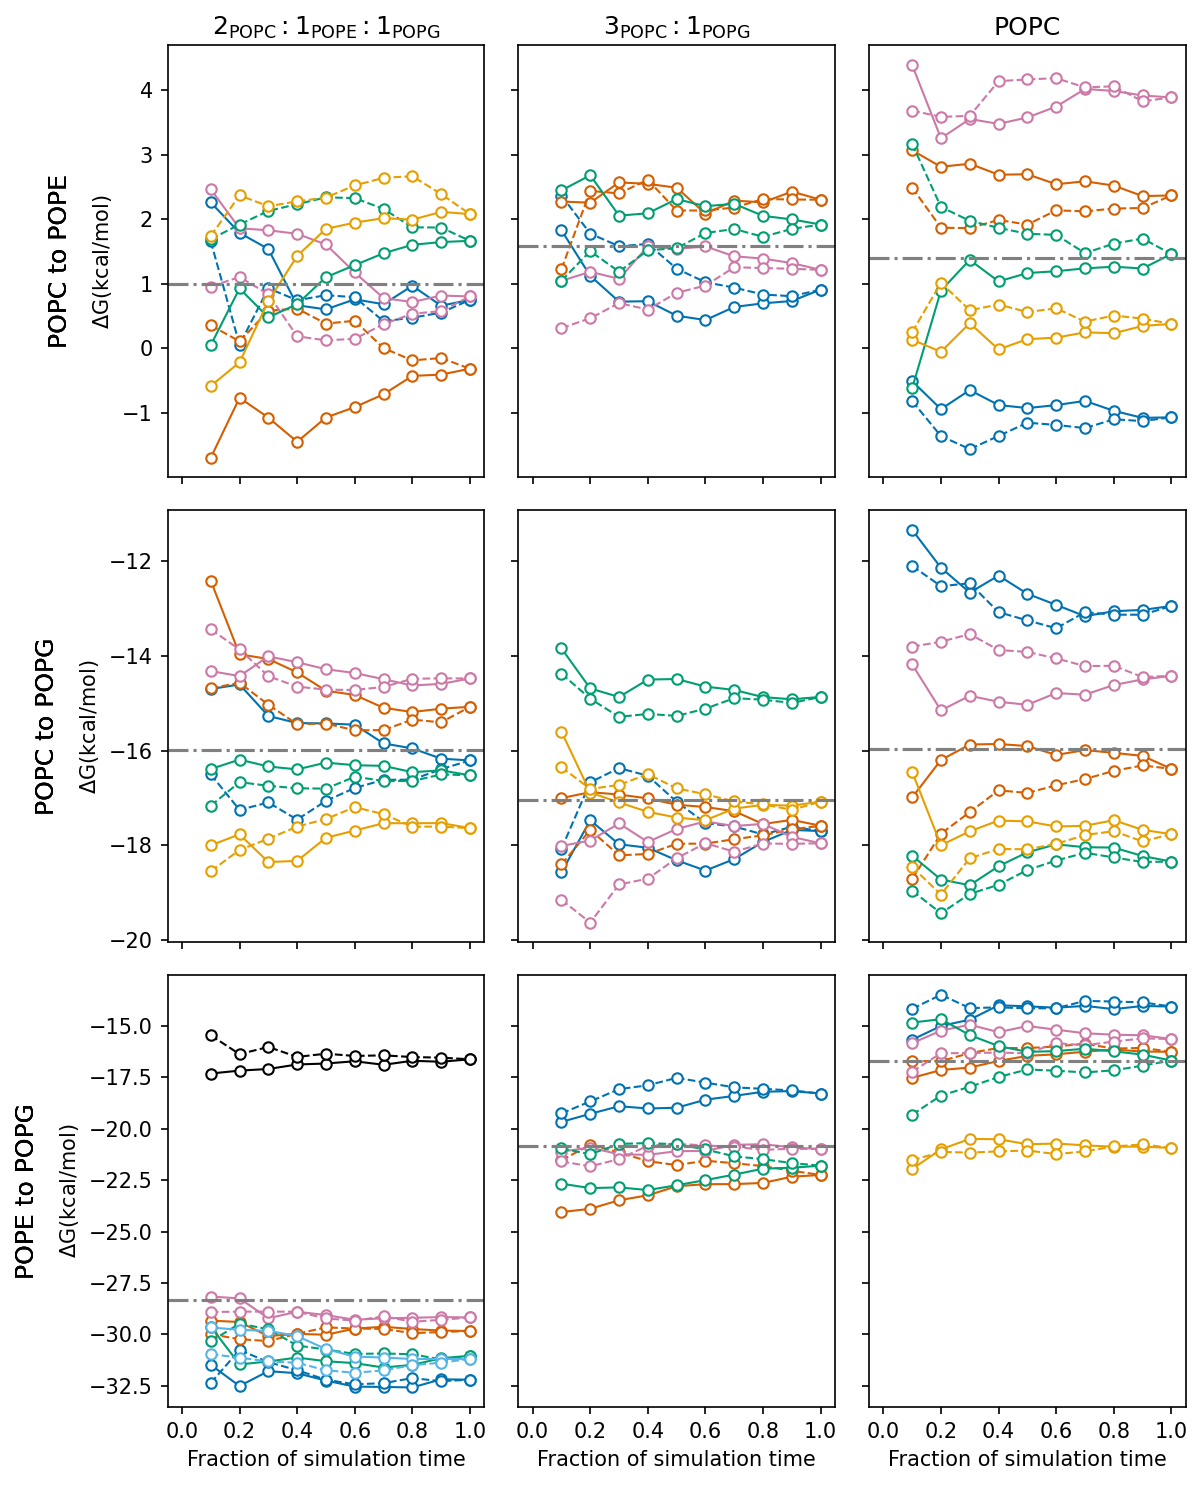

In [103]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel='Fraction of simulation time', ylabel=r'$\rm\Delta G (kcal/mol)$', doPlot=convergencePlot, sharey='row')
plt.savefig(f"{root}/DRAFT_S1.pdf")

In [97]:
for x in allSys['PCPG31']['cumulatives']['POEG'].keys():
    baseline = allSys['PCPG31']['cumulatives']['POGE'][x].iloc[-1]*-1
    allSys['PCPG31']['cumulatives']['POEG'][x] = (copy.deepcopy(allSys['PCPG31']['cumulatives']['POGE'][x]) + baseline)
    temp = np.flip(allSys['PCPG31']['cumulatives']['POEG'][x])
    temp.index = allSys['PCPG31']['cumulatives']['POEG'][x].index
    
    allSys['PCPG31']['cumulatives']['POEG'][x] = copy.deepcopy(temp)

In [101]:
allSys['PCPGPE211']['keyColors']['POEG']['POEG_Good'] = '#000000'

Now making figures for: PCPGPE211
Now making figures for: PCPG31
Now making figures for: POPC120


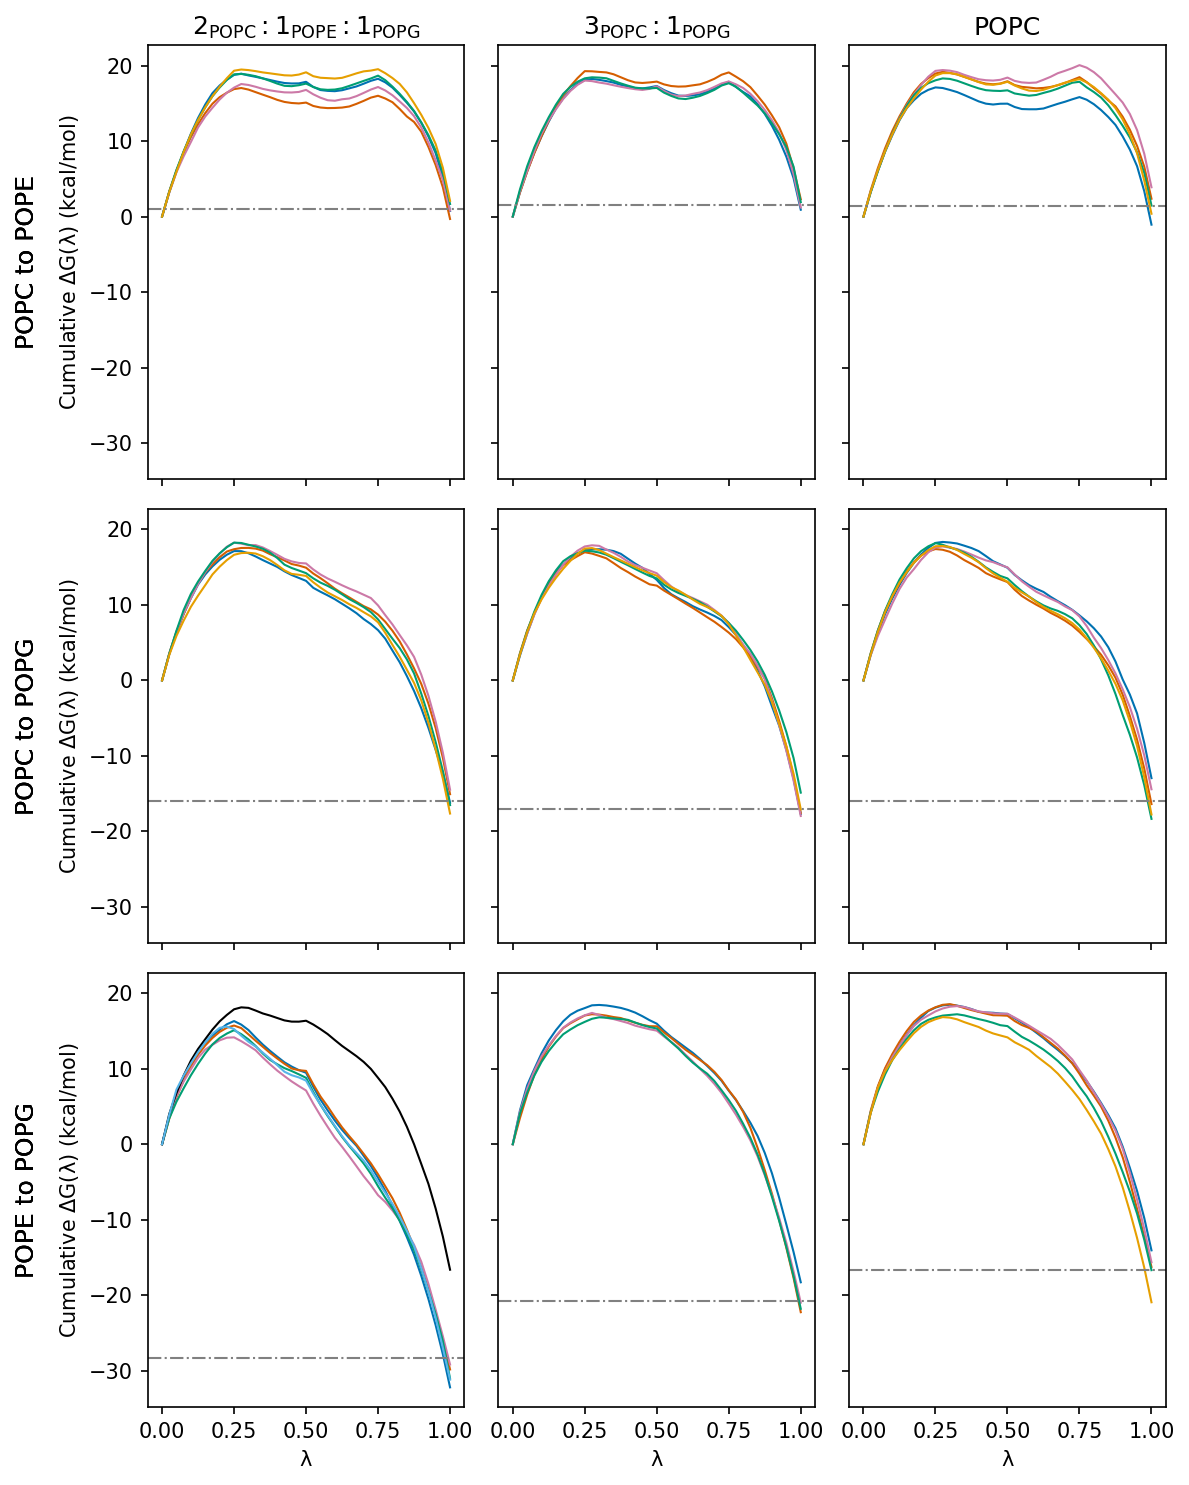

In [102]:
fig, dGaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\lambda$', ylabel=fr'Cumulative $\rm\Delta$G($\rm\lambda$) (kcal/mol)', doPlot=cumulativePlot)
plt.savefig(f"{root}/DRAFT_S4.pdf")